In [ ]:
import datetime
import json
import os
import pandas as pd
import geopy.distance
import itertools
import copy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import random
import sklearn.metrics as skmetrics
import io


In [ ]:
def general_normalize_scale(weight_list):
    min_value = np.min(weight_list)
    max_value = np.max(weight_list)
    return min_value, max_value

In [ ]:
def apply_scale(value, min_value, max_value):
    if min_value < 0:
        value = value - min_value
        min_value = 0
        max_value = max_value - min_value
    return (value - min_value) / (max_value-min_value)

In [ ]:
def remove_scale(value, min_value, max_value):
    if min_value < 0:
        value = value - min_value
        min_value = 0
        max_value = max_value - min_value
    norm_range = max_value - min_value
    return (value * norm_range) + min_value

### Below is for Model Searching Using Already Found "Best Model" Above.

### GridSearchCV for NN 

###### -------

In [ ]:
# This will prompt to import CSV's. Select nn_sales_data.csv in file path can be uploaded.
from google.colab import files
uploaded = files.upload()

Saving nn_sales_data.csv to nn_sales_data.csv


In [ ]:
df_csv = pd.read_csv(io.BytesIO(uploaded[f'nn_sales_data.csv']))
df = df_csv.loc[:,['REQUESTED_PRODUCT_ID','LOCAL_DELIVERY_WINDOW_DOW','LOCAL_DELIVERED_DAY','AVG_SAVED_PRODUCT_COST','NEXT_DAY_SALES']]
df.dropna(inplace=True)

In [ ]:
df = df[abs(df['NEXT_DAY_SALES'] - np.mean(df['NEXT_DAY_SALES']) ) < 1.96*np.mean(df['NEXT_DAY_SALES'])]

In [ ]:
df_dummies = pd.get_dummies(df,columns=['LOCAL_DELIVERY_WINDOW_DOW'])

In [ ]:
product_frequency = df_dummies.groupby(['REQUESTED_PRODUCT_ID'],
                                      as_index=False).size()   
product_frequency = pd.DataFrame(product_frequency).rename(columns={'size':'FREQUENCY'})

In [ ]:
df_dummies_freq = df_dummies.merge(product_frequency,
                                   how='left',
                                   on='REQUESTED_PRODUCT_ID')
df_dummies_freq_vars = df_dummies_freq.loc[:,~df_dummies_freq.columns.isin(['REQUESTED_PRODUCT_ID',
                                                               'NEXT_DAY_SALES'])]

df_dummies_freq_vars_norm = df_dummies_freq_vars.apply(lambda x: apply_scale(x,x.min(),x.max())).astype('float32')
df_dummies_freq_norm = df_dummies_freq.loc[:,['NEXT_DAY_SALES']]
df_dummies_freq_norm = df_dummies_freq_norm.apply(lambda x: apply_scale(x,x.min(),x.max())).astype('float32')

In [ ]:
from sklearn.model_selection import train_test_split
df_dummies_freq_vars_norm.dropna(inplace=True)
df_dummies_freq_norm.dropna(inplace=True)
df_dummies_freq_vars_norm = df_dummies_freq_vars_norm.loc[:,~df_dummies_freq_vars_norm.columns.isin(['REQUESTED_PRODUCT_ID',
                                                               'NEXT_DAY_SALES'])]
X_train, X_test, y_train, y_test = train_test_split(df_dummies_freq_vars_norm, 
                                                    df_dummies_freq_norm['NEXT_DAY_SALES'], 
                                                    test_size=0.2)

In [ ]:
#X_train_normalized=X_train.apply(lambda x: apply_scale(x,x.min(),x.max())).astype('float32')
#y_train_normalized=apply_scale(y_train,y_train.min(),y_train.max()).astype('float32')

#X_test_normalized=X_test.apply(lambda x: apply_scale(x,x.min(),x.max())).astype('float32')
#y_test_normalized=apply_scale(y_test,y_test.min(),y_test.max()).astype('float32')

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# from scikeras.wrappers import KerasClassifier, KerasRegressor
# supposed to be using above, but installation causing failures for others
from keras.callbacks import EarlyStopping

# define the model architecture
def create_model(hidden_layers=1, neurons=10, activation_fn_1='relu',
                 activation_fn_2='relu',
                 optimizer='adam',
                 loss='meas_squared_error'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation_fn_1))
    for i in range(hidden_layers):
        model.add(Dense(neurons, activation=activation_fn_2))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    return model

early_stop = EarlyStopping(monitor='loss',min_delta=0.001,patience=5)

# create a KerasRegressor object
model = KerasRegressor(build_fn=create_model, verbose=1)

# define the hyperparameters to search over
param_grid = {'hidden_layers': [3,5],
              'neurons': [10, 15],
              'activation_fn_1': ['relu','linear'],
              'activation_fn_2': ['relu','linear'],
              'optimizer': ['adam'],
              'loss':['mean_squared_error','huber_loss']}

# define the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# fit the GridSearchCV object to the training data
grid_result = grid.fit(X_train, y_train, epochs=100, callbacks=[early_stop])

<ipython-input-15-72ed0a886499>:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Epoch 1/100
6818/6818 [==============================] - 15s 2ms/step - loss: 0.0457
Epoch 2/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0435
Epoch 3/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0409
Epoch 4/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0360
Epoch 5/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0347
Epoch 6/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0337
Epoch 7/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0331
Epoch 8/100
6818/6818 [==============================] - 14s 2ms/step - loss: 0.0329
Epoch 9/100
6818/6818 [==============================] - 14s 2ms/step - loss: 0.0328
Epoch 10/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0326
Epoch 11/100
6818/6818 [==============================] - 13s 2ms/step - loss: 0.0325
Epoch 12/100
6818/6818 [==============================] - 13s 2

In [ ]:
grid_result.best_params_

{'activation_fn_1': 'relu',
 'activation_fn_2': 'relu',
 'hidden_layers': 5,
 'loss': 'huber_loss',
 'neurons': 15,
 'optimizer': 'adam'}

In [ ]:
# get the best parameters and create a new model with them
best_params = grid_result.best_params_
best_model = create_model(hidden_layers=best_params['hidden_layers'],
                          neurons=best_params['neurons'],
                          activation_fn_1=best_params['activation_fn_1'],
                          activation_fn_2=best_params['activation_fn_2'],
                          optimizer=best_params['optimizer'],
                          loss=best_params['loss'])

early_stop = EarlyStopping(monitor='loss',min_delta=0.0001,patience=5)
# train the best model on the entire training set
best_model.fit(X_train, y_train, epochs=100, batch_size=100, 
               callbacks=[early_stop])

# make predictions on new data using the best model
y_pred_test = best_model.predict(X_test)

Epoch 1/100
3273/3273 [==============================] - 9s 2ms/step - loss: 0.0222
Epoch 2/100
3273/3273 [==============================] - 7s 2ms/step - loss: 0.0209
Epoch 3/100
3273/3273 [==============================] - 8s 2ms/step - loss: 0.0182
Epoch 4/100
3273/3273 [==============================] - 7s 2ms/step - loss: 0.0166
Epoch 5/100
3273/3273 [==============================] - 8s 2ms/step - loss: 0.0163
Epoch 6/100
3273/3273 [==============================] - 7s 2ms/step - loss: 0.0160
Epoch 7/100
3273/3273 [==============================] - 7s 2ms/step - loss: 0.0160
Epoch 8/100
3273/3273 [==============================] - 8s 2ms/step - loss: 0.0159
Epoch 9/100
3273/3273 [==============================] - 7s 2ms/step - loss: 0.0158
Epoch 10/100
3273/3273 [==============================] - 8s 2ms/step - loss: 0.0158
Epoch 11/100
3273/3273 [==============================] - 7s 2ms/step - loss: 0.0157
Epoch 12/100
3273/3273 [==============================] - 8s 2ms/step - lo

In [ ]:
train_error = best_model.evaluate(X_train,y_train)
train_error

10227/10227 [==============================] - 16s 2ms/step - loss: 0.0154


0.015423830598592758

In [ ]:
#test_error = skmetrics.mean_squared_error(y_test_normalized,[i[0] for i in y_pred_test])
#test_error
import tensorflow.keras.losses as losses
import keras.backend as K
test_error = K.eval(losses.huber(y_test,[i[0] for i in y_pred_test]))
test_error

0.015155193

In [ ]:
denormalized_train_mse = remove_scale(train_error,
                                    df_dummies_freq['NEXT_DAY_SALES'].min(),
                                    df_dummies_freq['NEXT_DAY_SALES'].max())
denormalized_test_mse = remove_scale(test_error,
                                    df_dummies_freq['NEXT_DAY_SALES'].min(),
                                    df_dummies_freq['NEXT_DAY_SALES'].max())
print("train error: ",denormalized_train_mse,"\n",
      "test error: ",denormalized_test_mse)

train error:  0.314539719780162 
 test error:  0.30906137444218623


In [ ]:
from sklearn.inspection import permutation_importance
imp_df = pd.DataFrame()
imp = permutation_importance(best_model, X_test, y_test, scoring='r2');
imp_df['IMPORTANCES'] = imp.importances_mean
for i, feature in enumerate(X_test.columns):
    imp_df.rename(index={i:feature},inplace=True)

2557/2557 [==============================] - 3s 1ms/step


In [ ]:
imp_df.sort_values(by='IMPORTANCES',ascending=False)

,IMPORTANCES
FREQUENCY,0.667675
AVG_SAVED_PRODUCT_COST,0.497982
LOCAL_DELIVERY_WINDOW_DOW_Sun,0.350376
LOCAL_DELIVERY_WINDOW_DOW_Thu,0.343268
LOCAL_DELIVERY_WINDOW_DOW_Mon,0.332604
LOCAL_DELIVERY_WINDOW_DOW_Fri,0.332420
LOCAL_DELIVERY_WINDOW_DOW_Sat,0.270495
LOCAL_DELIVERY_WINDOW_DOW_Tue,0.236862
LOCAL_DELIVERY_WINDOW_DOW_Wed,0.148289
LOCAL_DELIVERED_DAY,0.142045


In [ ]:
p = [i[0] for i in remove_scale(y_pred_test,y_test.min(),y_test.max())]
pd.DataFrame({'Actuals':y_test,
              'Preds':p})
np.sqrt(skmetrics.mean_squared_error(y_test,p))

0.1740989

In [ ]:
mape = abs((y_test - p)/y_test)
mape[~np.isfinite(mape)] = 0
np.mean(mape)

0.37526825

In [ ]:
mae = abs((y_test - p))
mae[~np.isfinite(mae)] = 0
np.mean(mae)

0.12085916

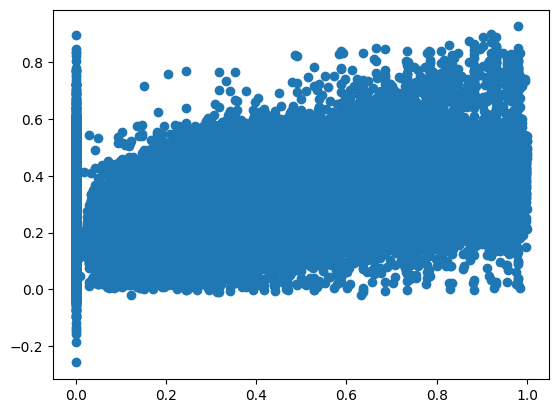

In [ ]:
plt.scatter(y_test, p)

In [ ]:
import statsmodels.api as sm
residuals = y_test - p

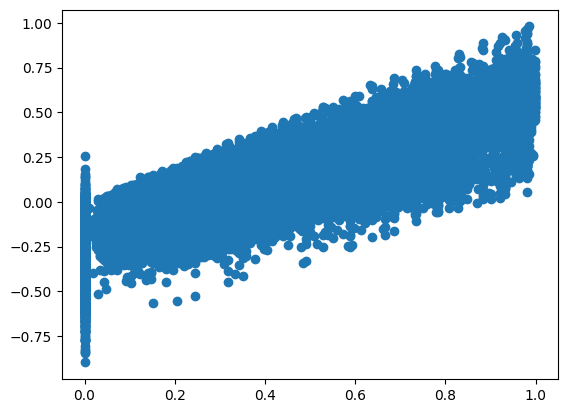

In [ ]:
plt.scatter(y_test,residuals)

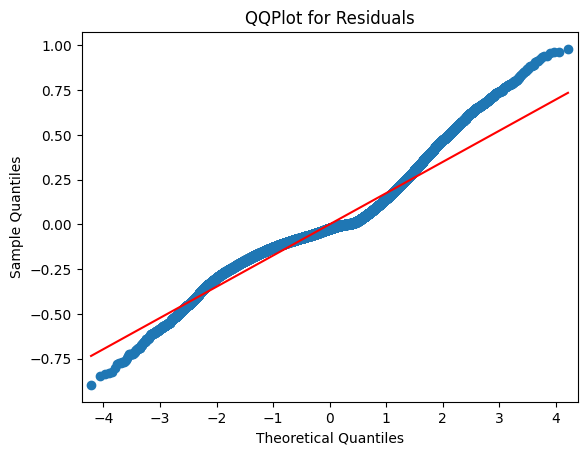

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('QQPlot for Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [ ]:
denormalized_y_test = remove_scale(y_test,
                                    df_dummies_freq['NEXT_DAY_SALES'].min(),
                                    df_dummies_freq['NEXT_DAY_SALES'].max())
denormalized_y_pred = remove_scale(y_pred_test,
                                    df_dummies_freq['NEXT_DAY_SALES'].min(),
                                    df_dummies_freq['NEXT_DAY_SALES'].max())

In [ ]:
pd.DataFrame({'Actuals':denormalized_y_test,
              'Predictions':[i[0] for i in denormalized_y_pred]})

,Actuals,Predictions
152140,0.000000,0.496464
353464,2.580000,0.639117
51462,4.990000,8.156309
336613,0.000000,-0.107169
347181,11.780001,5.857418
...,...,...
179436,7.630001,5.374499
176060,2.290000,5.825656
250356,6.580000,4.731927
348950,4.390000,5.280903


<Axes: >

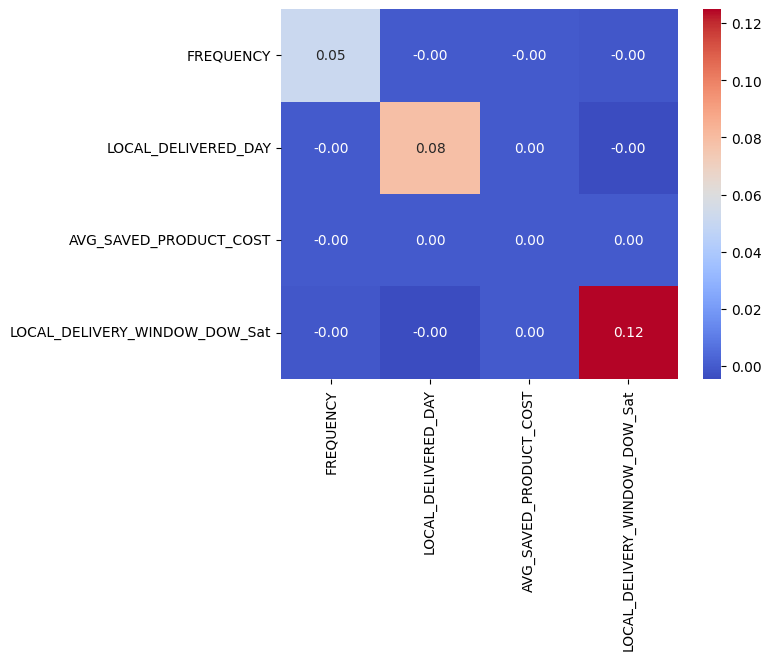

In [ ]:
import seaborn as sns
covariance_matrix = df_dummies_freq_vars_norm.loc[:,['FREQUENCY',
                                                    'LOCAL_DELIVERED_DAY',
                                                    'AVG_SAVED_PRODUCT_COST',
                                                    'LOCAL_DELIVERY_WINDOW_DOW_Sat']].cov()
sns.heatmap(covariance_matrix,cmap='coolwarm',annot=True,fmt='.2f')

<Axes: >

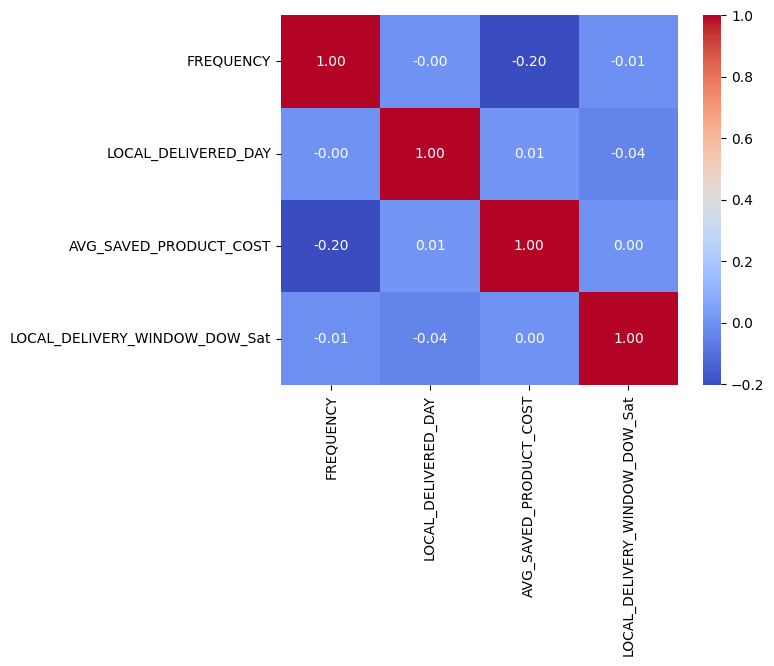

In [ ]:
import seaborn as sns
corr_matrix = df_dummies_freq_vars_norm.loc[:,['FREQUENCY',
                                                    'LOCAL_DELIVERED_DAY',
                                                    'AVG_SAVED_PRODUCT_COST',
                                               'LOCAL_DELIVERY_WINDOW_DOW_Sat']].corr()
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True,fmt='.2f')